In [1]:
%matplotlib inline
import numpy as np
import healpy as hp
import pandas as pd
import scipy.constants as const
from astropy.io import fits
from astropy.cosmology import WMAP5
from astropy import units as u

In [2]:
# User Inputs

#theta, phi, ul, ul_err = np.loadtxt('11yr_skymap_v4.txt', skiprows=1, unpack=True, usecols=(1,2,3,4))
data = np.genfromtxt('11yr_skymap_v4.txt', names=True)
#print(data['ul'])

# TODO: Put unit conversion for latitude
input_theta = .35
input_phi = 4.2

input_long = "43°2’27”"
input_lat = 40



In [3]:
orbital_s = 10.
orbital_p = 400.

# These unit conversions by no means need to be functions, just did so to make it clear for now
def yrs_to_s(years):
    return years*365*24*3600
def pc_to_m(pc):
    return pc*30856776e9
def kg_to_M0(kg):
    return kg/1.98847e30
def M0_to_kg(M0):
    return M0*1.98847e30
def m_to_pc(m):
    return m/30856776e9
def s_to_yrs(s):
    return s/(365*24*3600)

6.866e+12


In [ ]:
def totalmasscalc(orbital_s, orbital_p): 
    return kg_to_M0((4*(const.pi**2)*(pc_to_m(orbital_s/2))**3)/(const.G * (yrs_to_s(orbital_p))**2))

print("{:.3e}".format(totalmasscalc(orbital_s, orbital_p)))

In [4]:
def orbitalsepcalc(total_m, orbital_p):
    return 2*np.cbrt((const.G * M0_to_kg(total_m) * yrs_to_s(orbital_p)**2)/(4*(const.pi)**2))
print("{:.2f}".format(m_to_pc(orbitalsepcalc(6.865588e+12, 400))))

10.00


In [5]:
def orbitalpercalc(total_m, orbital_s):
    return s_to_yrs(np.sqrt((4 * (const.pi**2) * (pc_to_m(orbital_s)/2)**3)/(const.G * M0_to_kg(total_m))))
print("{:.2f}".format(orbitalpercalc(6.865588e+12, 10)))

400.00


In [6]:
#TODO: Either use astropy or manual linear approximation. Eventually would like to implement full expansion
# For astropy don't forget to strip units and convert to float
distance = .0237
def distancecalc(redshift):
    return (WMAP5.comoving_distance(redshift))
print("{:.2f}".format(distancecalc(.0237)))

100.71 Mpc


In [7]:
# TODO: This is the linear approximation I was talking about. Both will likely change slightly
# Ok so this answer seems really wrong, but actually that's just cuz it turns out this linear approximation is just really bad at long AND short distances. Will be fixed with full expansion.
def redshiftcalc(distance):
    H0 = 70
    return (distance*H0)/const.c
print(redshiftcalc(100.7105))

2.3515384766617443e-05


In [8]:
# TODO: Haven't done these units yet
def gwave_strain(total_m, orbital_p, distance):
    return (total_m**(5./3.))/((orbital_p**(2./3.))*distance)
print(gwave_strain(2e9, 400, 100))

584803547642.5743


In [9]:
#c1 = fits.Column(name='theta', array= theta, format=('D'))
#c2 = fits.Column(name='phi', array= phi, format=('D'))
#c3 = fits.Column(name='ul', array= ul, format=('D'))
#c4 = fits.Column(name='ul_err', array= ul_err, format=('D'))
#t = fits.BinTableHDU.from_columns([c1, c2, c3, c4])
#t.writeto('ul.fits', overwrite=True)
#skymap = hp.fitsfunc.mrdfits(t)
#hp.mollview(skymap, title= 'Upper Limit Skymap')


In [10]:
#x = radius * cos(latitude) * cos(longitude)
#y = radius * cos(latitude) * sin(longitude)
#z = radius * sin(latitude)

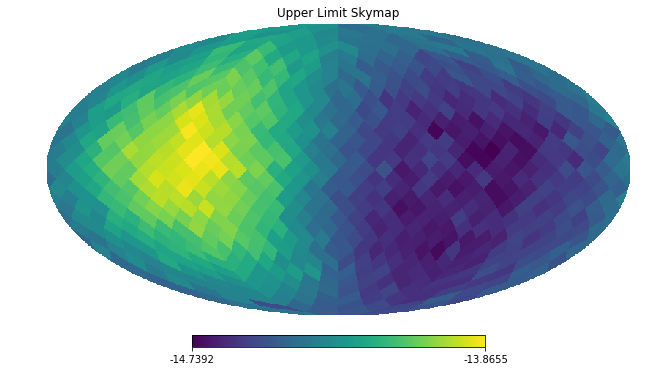

In [11]:
nside = 8
npix = hp.nside2npix(nside)
indices = hp.ang2pix(nside, data['theta'], data['phi'])
skymap = np.zeros(npix, dtype=np.float)
skymap[indices] += data['ul'][indices]
hp.mollview(np.log10(skymap), title= 'Upper Limit Skymap')

In [12]:
min_location = np.where(data['ul'] == data['ul'].min())[0]
theta_min, phi_min = hp.pix2ang(nside, min_location)

max_location = np.where(data['ul'] == data['ul'].max())[0]
theta_max, phi_max = hp.pix2ang(nside, max_location)

In [13]:
# TODO: Maybe figure out plotting stuff so that I can put a marker on the skymap based on the input theta and phi. Easy part is I know exactly how to find that pixel now, hard part is plotting these is ridiculous.
def find_ul(theta, phi):
    return hp.pixelfunc.get_interp_val(skymap, theta, phi)

print("The interpolated gravitational wave strain for theta = {0:.3f}, phi = {1:.3f} is: {2:.3e}".format(input_theta, input_phi, find_ul(input_theta, input_phi)))
print("For Context: ")
print('Least sensitive sky location is at theta = {0:.3f}, phi = {1:.3f}, with a value of {2:.3e}'.format(float(theta_max), float(phi_max), float(data['ul'][min_location])))
print('Most sensitive sky location:  theta_min = {0:.3f}, phi_min = {1:.3f}, with a value of {2:.3e}'.format(float(theta_min), float(phi_min), float(data['ul'][max_location])))


The interpolated gravitational wave strain for theta = 0.350, phi = 4.200 is: 3.864e-15
For Context: 
Least sensitive sky location is at theta = 1.487, phi = 1.571, with a value of 1.823e-15
Most sensitive sky location:  theta_min = 1.403, phi_min = 4.614, with a value of 1.363e-14
